# HW 1 for Projects in ML and AI

## Setup Stuff

In [1]:
# installing dependencyes

!pip install -q kaggle

In [2]:
# mount drive and set up kaggle API

from google.colab import drive
drive.mount('/content/drive')

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive
rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
# install dataset and unzip

!rm -r dataset

!kaggle datasets download -d saumitgp/occupancy-detection-dataset
!mkdir dataset
!unzip occupancy-detection-dataset.zip -d dataset

rm: cannot remove 'dataset': No such file or directory
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 54.5MB/s]
Archive:  occupancy-detection-dataset.zip
  inflating: dataset/OccupancyData/DataTest.csv  
  inflating: dataset/OccupancyData/DataTraining.csv  


## Task 1

Describe a machine learning problem that you would like to solve using Logistic Regression. Clearly state why Logistic regression is the best choice for solving this problem.

The problem of telling apart whether a room is occupied by a human or not (classificaion) can be solved using a classification algorithm and training on various features, such as light, co2, temperature, and humidity of a room. I found a dataset called occupation detection on [Kaggle](https://www.kaggle.com/datasets/saumitgp/occupancy-detection-dataset). The original dataset seems to be from [here](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+). The kaggle version seems to have similar number of rows, so I decided to stick to the Kaggle version


## Task 2

Pick a publicly available dataset (except The Titanic Dataset because we already discussed that in class) that you will use to solve this problem. You must provide a link to the dataset and perform necessary Exploratory Data Analysis (EDA). Clearly demonstrate the 
steps you follow for your EDA with a justification of why these were required. For example, if the dataset has lot of missing values, then why did you use a specific technique when handling missing data. This task may include data visualization (Check this link : https://www.geeksforgeeks.org/top-8-python-libraries-for-data-visualization/). The link for the dataset being used here is [this](https://www.kaggle.com/datasets/saumitgp/occupancy-detection-dataset)

First, we read in dataset and make a pretty df

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# the balance is weird, I will merge the train and test files first and split them to 8:2
df = pd.concat([
        pd.read_csv('dataset/OccupancyData/DataTraining.csv',index_col=[0]),
        pd.read_csv('dataset/OccupancyData/DataTest.csv',index_col=[0])
    ])
raw_vals = df.drop(columns=['date']).values
X,y = raw_vals[:,:-1],raw_vals[:,-1]
# pad X with 1 in the beginning, this will serve as our bias term
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=0)

# scaling the features just in case... turned out it's not really necessary
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


Check for NA values, and also for correlation between feature values.


We find no NA values, and the correlation seems OK! (high corr between humidity ratio and humidity itself is to be expected). I believe this shows that the dataset is adequate to be used for a binary classification task using Logistic Regression, because each variable seems to be independent of each other. 

I also checked the distribution of the labels, it seems that we have more entries for 'No Occupancy' than 'Occupancy'. 

checking if there is nan in any column
date             False
Temperature      False
Humidity         False
Light            False
CO2              False
HumidityRatio    False
Occupancy        False
dtype: bool


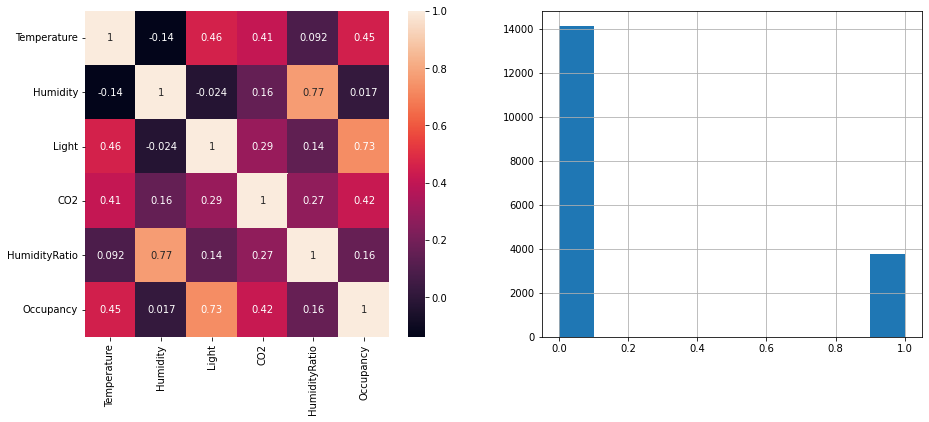

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

print('checking if there is nan in any column')
print(df.isna().any())

fig,axes = plt.subplots(ncols=2,figsize=(15,6))
sns.heatmap(
    df.corr(method='kendall'),
    ax=axes[0],
    annot=True
)

df.Occupancy.hist(ax=axes[1])

## Task 3

Implement Logistic Regression in this step. Clearly write your cost function and derivatives before implementing gradient descent. Do not use any built-in packages for this step. You can use the vectorization techniques demonstrated in class. Implement any 2 variants of gradient descent in their original form. (Refer to the research paper discussed in class).

I tested each variant with some varying learning rates and maximum iterations. For SGD, because of their long runtime, I maxed out the iterations at 500.

I implemented the vanilla (batched and minibatched) gradient descent and also the SGD. My cost function and activation are specified before the class, and each derivative is taken at the _update functions.

I found that while full and mini batches still work pretty well with this dataset, the SGD variants performed even better, although taking longer time to train due to increased number of iterations. With SGD, I also noted that starting with higher learning rates work better.

In [14]:
import numpy as np 
from tqdm.auto import tqdm
import random

np.random.seed(0)
random.seed(0)
# tiny offset to avoid zero division in logs
OFFSET = 1e-7

# My Activation and Cost functions (Both taken from lecture)
activation = lambda x: (1/(1+np.exp(-x)))
loss = lambda real,pred: -(real*np.log(pred+OFFSET) + (1-real)*np.log(1-pred+OFFSET))

class VanillaLogisticRegression():
    def __init__(self, learning_rate = 1e-3,n_iter=1000,mode = 'batch'):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.mode = mode
        self.batch_size = None
        if self.mode == 'minibatch':
            self.batch_size = 256
            # aside from the batch size, everything else is shared
            self.mode = 'batch'

    def fit(self,X_train,y_train):
        if not self.batch_size: self.batch_size = X_train.shape[0]
        self.W = np.random.random((1,X_train.shape[1]))
        self.B = np.random.random(1)
        self.losses = np.zeros(self.n_iter*X_train.shape[0])
        grad_func = self.batch_update if 'batch' in self.mode else self.SGD_update

        for i in range(self.n_iter):
            X_sample,y_sample = self.get_batch(X_train,y_train)
            # for b in range(n_batches):
            grad_func(X_sample,y_sample,i)

    def get_batch(self,X_train,y_train):
        idxs = np.arange(X_train.shape[0])
        np.random.shuffle(idxs)
        return X_train[idxs[:self.batch_size]],y_train[idxs[:self.batch_size]]

    def SGD_update(self,X_sample,y_sample,iter):
        for i,(real,example) in enumerate(zip(y_sample,X_sample)): 
            y_hat = self.predict_prob(example[None,:])
            dW = example * (y_hat - real)
            dB = y_hat - real
            self.W -= dW * self.learning_rate
            self.B -= dB * self.learning_rate
            self.losses[iter*X_sample.shape[0]+i] = loss(real,y_hat)
    
    def batch_update(self,X_sample,y_sample,iter):
        y_hat = self.predict_prob(X_sample)
        dW = X_sample.T @ (y_hat - y_sample)
        dB = (y_hat - y_sample).mean()
        self.W -= dW * self.learning_rate
        self.B -= dB * self.learning_rate
        # self.losses[iter] = l.sum()
        self.losses[iter*X_sample.shape[0] : (iter+1)*X_sample.shape[0]] = loss(y_sample,y_hat)

    def predict_prob(self,X):
        # Added slicing at end to return it flat
        return activation(X @ self.W.T + self.B)[:,0]

    def predict(self,X):
        return (self.predict_prob(X) > .5).astype(int)

    def score(self,X,y):
        pred = self.predict(X)
        return (y == pred).mean()

results = []


In [8]:
pbar = tqdm(total=2*4*6,desc='vanilla batched grads')
for mode in ['minibatch','batch',]:
    for n in [100,200,500,1000]:
        for lr in [5,2,1,.01,.001,.0001]:
            clf = VanillaLogisticRegression(n_iter=n,learning_rate=lr,mode=mode)
            clf.fit(X_train,y_train)
            output = {'mode':mode,'n':n,'lr':lr,'train':clf.score(X_train,y_train),'test':clf.score(X_test,y_test),}
            print(output)
            results.append({**output,'model':clf})
            pbar.update()
pbar.close()

vanilla batched grads:   0%|          | 0/48 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


{'mode': 'minibatch', 'n': 100, 'lr': 5, 'train': 0.9730371612182174, 'test': 0.9695445655210952}
{'mode': 'minibatch', 'n': 100, 'lr': 2, 'train': 0.9678681195864767, 'test': 0.9631181894383906}
{'mode': 'minibatch', 'n': 100, 'lr': 1, 'train': 0.9345487566359318, 'test': 0.9304274937133278}
{'mode': 'minibatch', 'n': 100, 'lr': 0.01, 'train': 0.9557138865604917, 'test': 0.9519418832075999}
{'mode': 'minibatch', 'n': 100, 'lr': 0.001, 'train': 0.886071528359877, 'test': 0.8882369376920928}
{'mode': 'minibatch', 'n': 100, 'lr': 0.0001, 'train': 0.6032411288069293, 'test': 0.6166526962838782}
{'mode': 'minibatch', 'n': 200, 'lr': 5, 'train': 0.9522212908633697, 'test': 0.9511036602402906}
{'mode': 'minibatch', 'n': 200, 'lr': 2, 'train': 0.9235820061469684, 'test': 0.9237217099748533}
{'mode': 'minibatch', 'n': 200, 'lr': 1, 'train': 0.9747834590667784, 'test': 0.9731768650461022}
{'mode': 'minibatch', 'n': 200, 'lr': 0.01, 'train': 0.9515926236378877, 'test': 0.946912545403744}
{'mode'

In [17]:
pbar = tqdm(total=1*3*6,desc='SGD')
for mode in ['SGD']:
    for n in [100,200,500]:
        for lr in [10,5,2,1,.01,.001]:
            clf = VanillaLogisticRegression(n_iter=n,learning_rate=lr,mode=mode)
            clf.fit(X_train,y_train)
            output = {'mode':mode,'n':n,'lr':lr,'train':clf.score(X_train,y_train),'test':clf.score(X_test,y_test),}
            print(output)
            results.append({**output,'model':clf})
            pbar.update()

pbar.close()

SGD:   0%|          | 0/18 [00:00<?, ?it/s]

{'mode': 'SGD', 'n': 100, 'lr': 10, 'train': 0.9817686504610227, 'test': 0.9754121262922604}
{'mode': 'SGD', 'n': 100, 'lr': 5, 'train': 0.9909192511874826, 'test': 0.9857502095557418}
{'mode': 'SGD', 'n': 100, 'lr': 2, 'train': 0.9906398435317127, 'test': 0.9851913942442023}
{'mode': 'SGD', 'n': 100, 'lr': 1, 'train': 0.9909192511874826, 'test': 0.9849119865884325}
{'mode': 'SGD', 'n': 100, 'lr': 0.01, 'train': 0.991617770326907, 'test': 0.9863090248672813}
{'mode': 'SGD', 'n': 100, 'lr': 0.001, 'train': 0.991617770326907, 'test': 0.9863090248672813}
{'mode': 'SGD', 'n': 200, 'lr': 10, 'train': 0.9917574741547919, 'test': 0.9851913942442023}
{'mode': 'SGD', 'n': 200, 'lr': 5, 'train': 0.9911288069293098, 'test': 0.9857502095557418}
{'mode': 'SGD', 'n': 200, 'lr': 2, 'train': 0.9907795473595976, 'test': 0.9851913942442023}
{'mode': 'SGD', 'n': 200, 'lr': 1, 'train': 0.9898016205644035, 'test': 0.9846325789326628}
{'mode': 'SGD', 'n': 200, 'lr': 0.01, 'train': 0.991617770326907, 'test':

Pick any 2 optimization algorithms that are used to optimize the ‘vanilla’
gradient descent. Implement both. You may implement these algorithms yourself OR use a package. In your conclusion, compare both optimization techniques/algorithms with respect to the results you achieve. Also compare these results with the original implementation of gradient descent (Task 3 above). Describe why or why not should we use optimization algorithms for the task at hand

## Task 4

For this task, I wrote the implementations in pytorch because it was easier to use the optimization techniques. I also took advantage of the built in gradients and sigmoid functions. 

I tried out RMSprop and Adam optimization techniques. I noted that these optimizations **did not** work very well with fully batched epoches, so I took the SGD approach of updating the weights for each example after shuffling at each epoch.
These implementations took significantly longer than the previous full and mini batch implementations on numpy, but they did show an improved performance, even with 10 epochs. Both optimizations improved the performance similarly, although Adam optimizer slightly outperformed RMS. I think if performance of the model comes before the computational need, than these optimizations should be used for this particular task in order to achieve a better model.

In [7]:
import torch
import random
# tiny offset to avoid zero division in logs
OFFSET = 1e-7

torch.manual_seed(0)

# My Activation and Cost functions (Both taken from lecture)
# gonna put them all on cuda because it takes longer than the numpy approach on cpu
X_train_torch,X_test_torch,y_train_torch,y_test_torch = torch.tensor(X_train).float(),torch.tensor(X_test).float(),torch.tensor(y_train).float(),torch.tensor(y_test).float()

class AdvancedLogisticRegression(torch.nn.Module):
    def __init__(self,input_size):
        super(AdvancedLogisticRegression,self).__init__()
        self.W = torch.nn.Linear(input_size,1)

    def forward(self,x):
        # this is the same as our activation function before
        # https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
        return torch.sigmoid(self.W(x))

Adam Optimization

  0%|          | 0/100 [00:00<?, ?it/s]

train: 0.9916875958442688 test: 0.9860296249389648


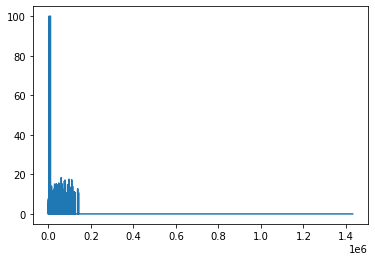

In [21]:
alr = AdvancedLogisticRegression(X_train_torch.size(1))
# this is our loss function, does the same thing as our loss lambda for vanilla
optimizer = torch.optim.Adam(alr.parameters(),lr=.1)
criterion = torch.nn.BCELoss()
losses = []
alr.train()
idxs = torch.arange(X_train_torch.size(0))
for epoch in tqdm(range(100)):
    # taking what I believe is the SGD approach?

    random.shuffle(idxs)
    for i in idxs:
        xx,yy = X_train_torch[i],y_train_torch[i]
        # clear optimizer memory
        optimizer.zero_grad()
        out = alr(xx)
        loss = criterion(out.squeeze(),yy)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

alr.eval()
train_pred = (alr(X_train_torch).squeeze() > .5).float()
test_pred = (alr(X_test_torch).squeeze() > .5).float()
print(f'train: {(train_pred == y_train_torch).float().mean()} test: {(test_pred == y_test_torch).float().mean()}')

sns.lineplot(data=losses)

# optimizer = torch.optim.RMSprop(alr.parameters(),lr=.001)

RMSprop Optimization

  0%|          | 0/100 [00:00<?, ?it/s]

train: 0.9863090515136719 test: 0.9812796711921692


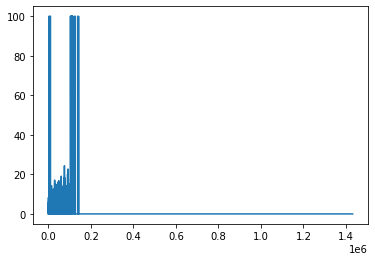

In [10]:
alr = AdvancedLogisticRegression(X_train_torch.size(1))
# this is our loss function, does the same thing as our loss lambda for vanilla
optimizer = torch.optim.RMSprop(alr.parameters(),lr=.1)
criterion = torch.nn.BCELoss()
losses = []
alr.train()
idxs = torch.arange(X_train_torch.size(0))

for epoch in tqdm(range(100)):
    random.shuffle(idxs)

    # taking what I believe is the SGD approach?
    for i in idxs:
        xx,yy = X_train_torch[i],y_train_torch[i]
        # clear optimizer memory
        optimizer.zero_grad()
        out = alr(xx)
        loss = criterion(out.squeeze(),yy)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

alr.eval()
train_pred = (alr(X_train_torch).squeeze() > .5).float()
test_pred = (alr(X_test_torch).squeeze() > .5).float()
print(f'train: {(train_pred == y_train_torch).float().mean()} test: {(test_pred == y_test_torch).float().mean()}')

sns.lineplot(data=losses)

# optimizer = torch.optim.RMSprop(alr.parameters(),lr=.001)